In [43]:
import torch
import transformers

In [44]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random

In [45]:
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
from openai import OpenAI
from concurrent.futures import ThreadPoolExecutor

In [ ]:
try:
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer("jinaai/jina-embeddings-v2-small-en")
    print("✅ SentenceTransformer model loaded successfully")
except Exception as e:
    print(f"❌ Failed to load SentenceTransformer: {e}")
    model = None


Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.3.intermediate.den

✅ SentenceTransformer model loaded successfully


In [48]:
# Load documents from processed JSON file
with open('../data/processed/documents-with-ids.json', 'r') as f:
    documents = json.load(f)

# Load ground truth dataset for evaluation from CSV file
df_ground_truth = pd.read_csv('../data/processed/ground-truth-retrieval.csv')
ground_truth = df_ground_truth.to_dict(orient='records')

print(f"Loaded {len(documents)} documents and {len(ground_truth)} ground truth questions")

Loaded 149 documents and 735 ground truth questions


In [49]:
documents[10]

{'location': 'Andhra_Pradesh',
 'doc_id': 'd4402d82c0',
 'content': "Andhra Pradesh is known for its rich history, architecture and culture. Andhra Pradesh has a variety of tourist attractions including beaches, hills, wildlife, forests and temples. Like rest of the Southern India, the culture of Andhra Pradesh is essentially Dravidian, quite different from North India's Sanskrit Hindu culture. Andhra Pradesh was part of the British Madras presidency and then independent India's Madras State until 1953, when Andhra State was formed, with the capital being",
 'id': '450a9d36'}

In [50]:
ground_truth[10]

{'question': 'What are the must-see religious temples to visit in Andhra Pradesh?',
 'id': 'db0beb52'}

In [51]:
# Create a merged dataframe by joining ground-truth with documents on 'id' column
df_documents = pd.DataFrame(documents)
df_merged = df_ground_truth.merge(df_documents, on='id', how='inner')
merged_data = df_merged.to_dict(orient='records')
with open('../data/processed/ques-docs-pairs.json', 'w') as f:
    json.dump(merged_data, f, indent=2)
    
print(f"Created merged dataset with {len(merged_data)} question-document pairs")
print(f"Sample merged record keys: {list(merged_data[0].keys()) if merged_data else 'No data'}")

Created merged dataset with 745 question-document pairs
Sample merged record keys: ['question', 'id', 'location', 'doc_id', 'content']


In [52]:
# Create document index for quick lookup
doc_idx = {d['id']: d for d in documents}

In [53]:
doc_idx['db0beb52']['content']

'Northern Coast (Alluri Sitharama Raju, Anakapalli, East Godavari, Kakinada, Konaseema, Parvathipuram Manyam, Srikakulam, Visakhapatnam, Vizianagaram, Yanam) Central Coast (Eluru, Krishna, NTR, West Godavari) Southern Coast (Bapatla, Guntur, Nellore, Palnadu, Prakasam, Tirupati) Rayalaseema (Annamayya, Anantapur, Chittoor, Kadapa, Kurnool, Nandyal, Sri Sathya Sai)  \n![0_image_1.png](0_image_1.png) interactive map'

 #### Index data

In [54]:
# Initialize sentence transformer model
model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [55]:
# Generate vectors for all documents
vectors = []
for doc in tqdm(documents):
    # Use content field instead of question + text
    content = doc['content']
    vector = model.encode(content)
    vectors.append(vector)

vectors = np.array(vectors)

  0%|          | 0/149 [00:00<?, ?it/s]

In [56]:
# Create vector search index
from minsearch import VectorSearch

vindex = VectorSearch(keyword_fields=['location'])
vindex.fit(vectors, documents)

### Retrieval


In [57]:
def minsearch_vector_search(vector, location):
    return vindex.search(
        vector,
        filter_dict={'location': location},
        num_results=5
    )

def question_text_vector(q):
    question = q['question']
    location = q.get('location', None)  # Get location if available, otherwise None
    v_q = model.encode(question)
    
    if location:
        return minsearch_vector_search(v_q, location)
    else:
        # If no location specified, search without filter
        return vindex.search(v_q, num_results=5)

In [58]:
# Test vector search functionality
test_question = {
    'question': 'What are the must-see religious sites in Andhra Pradesh?',
}
search_results = question_text_vector(test_question)
print(f"Found {len(search_results)} relevant documents")

Found 5 relevant documents


In [59]:
search_results

[{'location': 'Andhra_Pradesh',
  'doc_id': 'd4402d82c0',
  'content': 'Andhra Pradesh (AP) is a state in Southern India, with Bay of Bengal on the east and shares boundaries with Telangana on the north, Chhattisgarh and Odisha on the north-east, Tamil Nadu on the south and Karnataka on the west. Vijayawada is the capital of this state.',
  'id': 'a411c9aa'},
 {'location': 'Andhra_Pradesh',
  'doc_id': 'd4402d82c0',
  'content': "Andhra Pradesh is known for its rich history, architecture and culture. Andhra Pradesh has a variety of tourist attractions including beaches, hills, wildlife, forests and temples. Like rest of the Southern India, the culture of Andhra Pradesh is essentially Dravidian, quite different from North India's Sanskrit Hindu culture. Andhra Pradesh was part of the British Madras presidency and then independent India's Madras State until 1953, when Andhra State was formed, with the capital being",
  'id': '450a9d36'},
 {'location': 'Andhra_Pradesh',
  'doc_id': '9eb52

#### The RAG flow with Travel Assistant Prompt

In [60]:
def build_prompt(query, search_results):
    prompt_template = """
You're a travel assistant bot that helps users plan their itinerary and discover amazing places to visit.
Answer the QUESTION based on the CONTEXT from the travel database.
Use only the facts from the CONTEXT when answering the QUESTION.

When answering, consider:
- Must-visit tourist attractions and landmarks
- Cultural experiences and local traditions  
- Historical significance of places
- Best times to visit and travel tips
- Local cuisine and specialties (if mentioned in context)
- Transportation and accessibility information (if available)

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    for doc in search_results:
        location = doc.get('location', 'Unknown')
        content = doc.get('content', doc.get('text', ''))  # Handle both content and text fields
        context = context + f"location: {location}\ncontent: {content}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [61]:
# Initialize OpenAI client
client = OpenAI()

In [62]:
def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

In [63]:
def rag(query: dict, model='gpt-4o') -> str:
    search_results = question_text_vector(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

#### Single Example Evaluation Across All Models

In [64]:
ground_truth[10]

{'question': 'What are the must-see religious temples to visit in Andhra Pradesh?',
 'id': 'db0beb52'}

In [65]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [66]:
# Select 25 random examples for evaluation across all models
sample_size = 25
sample_questions = random.sample(ground_truth, min(sample_size, len(ground_truth)))

print(f"Selected {len(sample_questions)} random questions for evaluation:")
for i, q in enumerate(sample_questions[:5]):  # Show first 5 as preview
    print(f"{i+1}. Question: {q['question'][:100]}...")
    print(f"   Document ID: {q['id']}")

Selected 25 random questions for evaluation:
1. Question: Do foreign travelers need a visa and passport to visit Karnataka?...
   Document ID: 7adcc584
2. Question: What is the historical importance of Penukonda in the context of the Vijayanagara empire?...
   Document ID: 032385d9
3. Question: What are the main cultural and spiritual centers to visit in Andhra Pradesh?...
   Document ID: dceae12c
4. Question: Which species of animals and birds might I encounter in Bandipur National Park?...
   Document ID: 2ffbfa3d
5. Question: What are some must-visit cultural and natural attractions in Karnataka?...
   Document ID: 56d1a83b


In [67]:
# Prepare all question dictionaries for RAG
sample_question_dicts = []
for sample_question in sample_questions:
    doc_id = sample_question['id']
    original_doc = doc_idx[doc_id]
    sample_location = original_doc.get('location', 'Unknown')
    
    question_dict = {
        'question': sample_question['question'],
        'location': sample_location,
        'id': doc_id
    }
    sample_question_dicts.append(question_dict)

print(f"Prepared {len(sample_question_dicts)} question dictionaries for RAG evaluation")

Prepared 25 question dictionaries for RAG evaluation


In [68]:
# Test all GPT models on the 25 examples
models_to_test = ['gpt-3.5-turbo', 'gpt-4o', 'gpt-4o-mini']
multiple_examples_results = []

for model_name in models_to_test:
    print(f"\nTesting model: {model_name}")
    
    for i, (sample_question, question_dict) in enumerate(zip(sample_questions, sample_question_dicts)):
        try:
            print(f"  Processing question {i+1}/{len(sample_questions)}...")
            
            # Get original answer from documents
            doc_id = sample_question['id']
            original_doc = doc_idx[doc_id]
            answer_orig = original_doc['content']
            
            # Generate answer using RAG
            answer_llm = rag(question_dict, model=model_name)
            
            result = {
                'model': model_name,
                'question_id': i+1,
                'question': question_dict['question'],
                'location': question_dict['location'],
                'document_id': doc_id,
                'answer_orig': answer_orig,
                'answer_llm': answer_llm
            }
            multiple_examples_results.append(result)
            
        except Exception as e:
            print(f"    Error with model {model_name}, question {i+1}: {e}")

print(f"\nCompleted evaluation. Generated {len(multiple_examples_results)} results.")


Testing model: gpt-3.5-turbo
  Processing question 1/25...
  Processing question 2/25...
  Processing question 3/25...
  Processing question 4/25...
  Processing question 5/25...
  Processing question 6/25...
  Processing question 7/25...
  Processing question 8/25...
  Processing question 9/25...
  Processing question 10/25...
  Processing question 11/25...
  Processing question 12/25...
  Processing question 13/25...
  Processing question 14/25...
  Processing question 15/25...
  Processing question 16/25...
  Processing question 17/25...
  Processing question 18/25...
  Processing question 19/25...
  Processing question 20/25...
  Processing question 21/25...
  Processing question 22/25...
  Processing question 23/25...
  Processing question 24/25...
  Processing question 25/25...

Testing model: gpt-4o
  Processing question 1/25...
  Processing question 2/25...
  Processing question 3/25...
  Processing question 4/25...
  Processing question 5/25...
  Processing question 6/25...
 

In [69]:
df_multiple_examples = pd.DataFrame(multiple_examples_results)

In [70]:
# Display summary statistics
print(f"\nResults summary:")
print(f"Total results: {len(multiple_examples_results)}")
print(f"Results per model:")
for model in models_to_test:
    count = len(df_multiple_examples[df_multiple_examples['model'] == model])
    print(f"  {model}: {count} results")


Results summary:
Total results: 75
Results per model:
  gpt-3.5-turbo: 25 results
  gpt-4o: 25 results
  gpt-4o-mini: 25 results


In [71]:
# Save multiple examples results
df_multiple_examples.to_csv('../results/multiple_examples_comparison.csv', index=False)
print("Saved multiple examples results to: results/multiple_examples_comparison.csv")

Saved multiple examples results to: results/multiple_examples_comparison.csv


#### Cosine Similarity Metric 

In [72]:
def compute_similarity(record):
    """Calculate cosine similarity between original and LLM answers"""
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [ ]:
def compute_similarity(record):
    try:
        answer_orig = record['answer_orig']
        answer_llm = record['answer_llm']
        
        # Convert to strings and handle None values
        answer_llm = str(answer_llm) if answer_llm is not None else ""
        answer_orig = str(answer_orig) if answer_orig is not None else ""
        
        # Skip if either is empty
        if not answer_llm.strip() or not answer_orig.strip():
            return 0.0
        
        v_llm = model.encode(answer_llm)
        v_orig = model.encode(answer_orig)
        
        return v_llm.dot(v_orig)
        
    except Exception as e:
        print(f"Error processing record: {record}")
        print(f"Error: {e}")
        return 0.0  # or return None

In [76]:
# Calculate cosine similarities for all models and all examples
cosine_similarities_all = []

print("Calculating cosine similarities for all examples...")
for i, result in enumerate(tqdm(multiple_examples_results)):
    similarity = compute_similarity(result)
    cosine_similarities_all.append({
        'model': result['model'],
        'question_id': result['question_id'],
        'cosine_similarity': similarity,
        'question': result['question']
    })

Calculating cosine similarities for all examples...


  0%|          | 0/75 [00:00<?, ?it/s]

LookupError: unknown encoding: Foreign travelers visiting Karnataka will need a visa and passport to enter the state, as with entering any state in India. It is important to have the necessary travel documents when planning a trip to Karnataka to avoid any issues upon arrival.

In [ ]:
# Convert to DataFrame
df_similarities_all = pd.DataFrame(cosine_similarities_all)

In [77]:
# Calculate summary statistics
similarity_stats = df_similarities_all.groupby('model')['cosine_similarity'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median'
]).round(4)
print("\nCosine Similarity Statistics by Model:")
print(similarity_stats)


Cosine Similarity Statistics by Model:
               count        mean        std         min         max  \
model                                                                 
gpt-3.5-turbo     25  339.673889  40.448502  231.639099  416.498413   
gpt-4o            25  337.053406  41.856098  242.224396  397.559601   
gpt-4o-mini       25  333.478210  40.722000  232.546295  409.327606   

                   median  
model                      
gpt-3.5-turbo  344.909698  
gpt-4o         337.513702  
gpt-4o-mini    339.849396  


In [ ]:
from scipy.stats import gaussian_kde


# Define the three models to compare
models_to_compare = ['gpt-3.5-turbo', 'gpt-4o', 'gpt-4o-mini']
colors = ['green', 'blue', 'orange']
model_labels = ['GPT-3.5 Turbo', 'GPT-4o', 'GPT-4o Mini']

# Sample data for each model
sampled_data = {}

for model in models_to_compare:
    model_data = df_similarities_all[df_similarities_all['model'] == model]['cosine_similarity']
    if len(model_data) >= sample_size:
        sampled_data[model] = model_data.sample(n=sample_size, random_state=42).values
    else:
        sampled_data[model] = model_data.values
        print(f"Warning: Only {len(model_data)} samples available for {model}")

plt.figure(figsize=figsize)

# Create histograms for each model
for i, (model, color, label) in enumerate(zip(models_to_compare, colors, model_labels)):
    if model in sampled_data:
        plt.hist(sampled_data[model], bins=20, density=True, alpha=0.4, 
                label=label, color=color, edgecolor='black', linewidth=0.5)

# Create smooth KDE curves
x_vals = np.linspace(0, 1, 300)

for i, (model, color) in enumerate(zip(models_to_compare, colors)):
    if model in sampled_data and len(sampled_data[model]) > 1:
        kde = gaussian_kde(sampled_data[model])
        plt.plot(x_vals, kde(x_vals), color=color, lw=2.5)

# Add interpretation lines
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, 
            label='Moderate Similarity', linewidth=1)
plt.axvline(x=0.7, color='darkred', linestyle='--', alpha=0.7, 
            label='High Similarity', linewidth=1)

# Customize the plot
plt.title('Travel Assistant RAG - Model Performance Comparison\n(Cosine Similarity Between Original and Generated Answers)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Cosine Similarity Score', fontsize=14, fontweight='bold')
plt.ylabel('Density', fontsize=14, fontweight='bold')

# Add sample information
plt.figtext(0.5, 0.02, f'Sample Size: {sample_size} questions per model (Total: {sample_size * len(models_to_compare)} samples)', 
            ha='center', fontsize=10, style='italic')

interpretation_text = 
plt.figtext(0.02, 0.65, interpretation_text, fontsize=9, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))

plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)

# Calculate and display summary statistics
print("\n=== SUMMARY STATISTICS ===")
for i, model in enumerate(models_to_compare):
    if model in sampled_data:
        data = sampled_data[model]
        print(f"\n{model_labels[i]}:")
        print(f"  Mean: {np.mean(data):.3f}")
        print(f"  Std:  {np.std(data):.3f}")
        print(f"  Median: {np.median(data):.3f}")
        print(f"  Samples: {len(data)}")
        
        # Performance classification
        excellent = np.sum(data > 0.7)
        good = np.sum((data >= 0.5) & (data <= 0.7))
        needs_improvement = np.sum(data < 0.5)
        
        print(f"  Excellent (>0.7): {excellent}/{len(data)} ({excellent/len(data)*100:.1f}%)")
        print(f"  Good (0.5-0.7): {good}/{len(data)} ({good/len(data)*100:.1f}%)")
        print(f"  Needs Improvement (<0.5): {needs_improvement}/{len(data)} ({needs_improvement/len(data)*100:.1f}%)")

plt.tight_layout()
plt.show()

return sampled_data


In [ ]:
sampled_data = create_rag_comparison_histogram(df_similarities_all, sample_size=25)

In [ ]:
# # Save similarities to CSV
# df_similarities_all.to_csv('../results/cosine_similarities.csv', index=False)

In [ ]:
#Create detailed statistical comparison
print("=== DETAILED COSINE SIMILARITY ANALYSIS ===")
print("\nSummary Statistics:")
print(similarity_stats)

print("\nPerformance Classification:")
for model_name in models_to_test:
    model_similarities = df_similarities_all[df_similarities_all['model'] == model_name]['cosine_similarity']
    
    excellent = len(model_similarities[model_similarities > 0.7])
    good = len(model_similarities[(model_similarities >= 0.5) & (model_similarities <= 0.7)])
    needs_improvement = len(model_similarities[model_similarities < 0.5])
    total = len(model_similarities)
    
    print(f"\n{model_name}:")
    print(f"  Excellent (>0.7): {excellent}/{total} ({excellent/total*100:.1f}%)")
    print(f"  Good (0.5-0.7): {good}/{total} ({good/total*100:.1f}%)")
    print(f"  Needs Improvement (<0.5): {needs_improvement}/{total} ({needs_improvement/total*100:.1f}%)")


=== DETAILED COSINE SIMILARITY ANALYSIS ===

Summary Statistics:
               count  mean  std  min  max  median
model                                            
gpt-3.5-turbo     15   0.0  0.0  0.0  0.0     0.0
gpt-4o            15   0.0  0.0  0.0  0.0     0.0
gpt-4o-mini       15   0.0  0.0  0.0  0.0     0.0

Performance Classification:

gpt-3.5-turbo:
  Excellent (>0.7): 0/15 (0.0%)
  Good (0.5-0.7): 0/15 (0.0%)
  Needs Improvement (<0.5): 15/15 (100.0%)

gpt-4o:
  Excellent (>0.7): 0/15 (0.0%)
  Good (0.5-0.7): 0/15 (0.0%)
  Needs Improvement (<0.5): 15/15 (100.0%)

gpt-4o-mini:
  Excellent (>0.7): 0/15 (0.0%)
  Good (0.5-0.7): 0/15 (0.0%)
  Needs Improvement (<0.5): 15/15 (100.0%)


#### LLM-as-a-Judge Evaluation

In [ ]:
# LLM-as-a-Judge evaluation prompts
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [ ]:
# Evaluate subset of examples using LLM-as-a-Judge (due to cost considerations)
# Select 5 examples from each model (15 total evaluations)
evaluation_sample_size = 5
evaluations_aqa = []
evaluations_qa = []

print("Performing LLM-as-a-Judge evaluation on sample of results...")

for model_name in models_to_test:
    model_results = [r for r in multiple_examples_results if r['model'] == model_name]
    sample_results = random.sample(model_results, min(evaluation_sample_size, len(model_results)))
    
    print(f"\nEvaluating {len(sample_results)} examples for {model_name}...")
    
    # A>Q>A evaluation
    for result in sample_results:
        try:
            prompt = prompt1_template.format(**result)
            evaluation_str = llm(prompt, model='gpt-4o-mini')
            evaluation = json.loads(evaluation_str)
            evaluation['model'] = result['model']
            evaluation['question_id'] = result['question_id']
            evaluation['evaluation_type'] = 'Answer-Question-Answer'
            evaluations_aqa.append(evaluation)
        except (json.JSONDecodeError, Exception) as e:
            print(f"  Failed AQA evaluation for {model_name}, question {result['question_id']}: {e}")
    
    # Q>A evaluation
    for result in sample_results:
        try:
            prompt = prompt2_template.format(**result)
            evaluation_str = llm(prompt, model='gpt-4o-mini')
            evaluation = json.loads(evaluation_str)
            evaluation['model'] = result['model']
            evaluation['question_id'] = result['question_id']
            evaluation['evaluation_type'] = 'Question-Answer'
            evaluations_qa.append(evaluation)
        except (json.JSONDecodeError, Exception) as e:
            print(f"  Failed QA evaluation for {model_name}, question {result['question_id']}: {e}")


Performing LLM-as-a-Judge evaluation on sample of results...

Evaluating 5 examples for gpt-3.5-turbo...

Evaluating 5 examples for gpt-4o...

Evaluating 5 examples for gpt-4o-mini...


In [ ]:
# Combine all evaluations
all_evaluations_multiple = evaluations_aqa + evaluations_qa
df_evaluations_multiple = pd.DataFrame(all_evaluations_multiple)

In [ ]:
print(f"\nCompleted LLM-as-a-Judge evaluation:")
print(f"Total evaluations: {len(all_evaluations_multiple)}")
print(f"AQA evaluations: {len(evaluations_aqa)}")
print(f"QA evaluations: {len(evaluations_qa)}")


Completed LLM-as-a-Judge evaluation:
Total evaluations: 30
AQA evaluations: 15
QA evaluations: 15


In [ ]:
# Display evaluation summary
print("\nLLM-as-a-Judge Evaluation Summary:")
eval_summary = df_evaluations_multiple.groupby(['model', 'evaluation_type', 'Relevance']).size().unstack(fill_value=0)
print(eval_summary)


LLM-as-a-Judge Evaluation Summary:
Relevance                             NON_RELEVANT  PARTLY_RELEVANT  RELEVANT
model         evaluation_type                                                
gpt-3.5-turbo Answer-Question-Answer             0                2         3
              Question-Answer                    0                1         4
gpt-4o        Answer-Question-Answer             2                1         2
              Question-Answer                    0                1         4
gpt-4o-mini   Answer-Question-Answer             1                3         1
              Question-Answer                    0                1         4


In [ ]:
# # Save LLM-as-a-Judge evaluations
# df_evaluations_multiple.to_csv('../results/llm_as_a_judge_evaluations.csv', index=False)

Text(0.5, 0.98, 'LLM-as-a-Judge Evaluation Results - Multiple Examples')

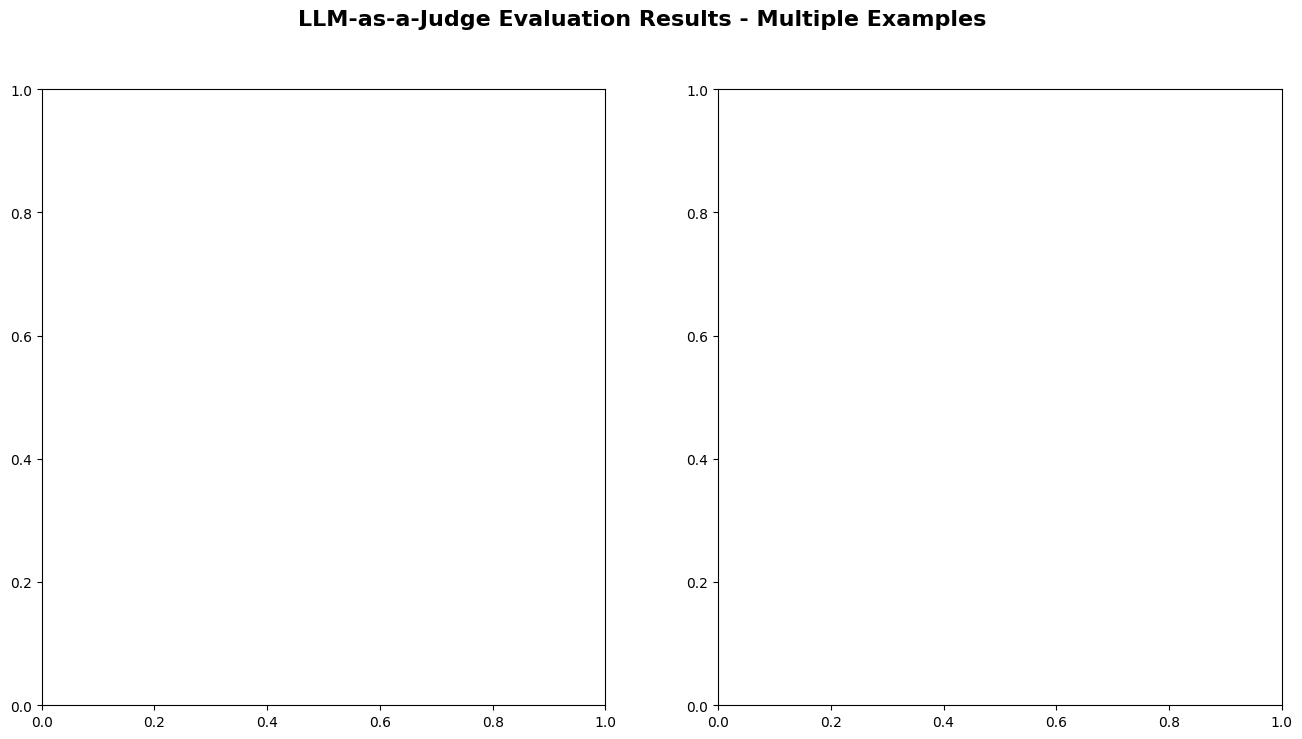

In [ ]:
# Create visualization for LLM-as-a-Judge results
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('LLM-as-a-Judge Evaluation Results - Multiple Examples', fontsize=16, fontweight='bold')


In [ ]:
# Plot AQA evaluations
aqa_data = df_evaluations_multiple[df_evaluations_multiple['evaluation_type'] == 'Answer-Question-Answer']
if len(aqa_data) > 0:
    aqa_counts = aqa_data.groupby(['model', 'Relevance']).size().unstack(fill_value=0)
    aqa_counts.plot(kind='bar', ax=axes[0], title='Answer-Question-Answer Evaluation', 
                    color=['#FF6B6B', '#FFD93D', '#6BCF7F'])
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('Count')
    axes[0].legend(title='Relevance')
    axes[0].tick_params(axis='x', rotation=45)

In [ ]:
# Plot QA evaluations
qa_data = df_evaluations_multiple[df_evaluations_multiple['evaluation_type'] == 'Question-Answer']
if len(qa_data) > 0:
    qa_counts = qa_data.groupby(['model', 'Relevance']).size().unstack(fill_value=0)
    qa_counts.plot(kind='bar', ax=axes[1], title='Question-Answer Evaluation',
                   color=['#FF6B6B', '#FFD93D', '#6BCF7F'])
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Count')
    axes[1].legend(title='Relevance')
    axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
# plt.savefig('../images/llm_as_a_judge_evaluation_multiple.png', dpi=300, bbox_inches='tight')

#### Comprehensive summary Results

In [ ]:
print("=== COMPREHENSIVE EVALUATION SUMMARY (15 Examples) ===")

print(f"\n1. DATASET INFORMATION:")
print(f"   • Total examples evaluated: {len(sample_questions)}")
print(f"   • Models tested: {', '.join(models_to_test)}")
print(f"   • Total RAG generations: {len(multiple_examples_results)}")

print(f"\n2. COSINE SIMILARITY ANALYSIS:")
print("   Mean ± Std Dev by Model:")
for model in models_to_test:
    model_data = df_similarities_all[df_similarities_all['model'] == model]['cosine_similarity']
    print(f"   • {model}: {model_data.mean():.4f} ± {model_data.std():.4f}")

print(f"\n   Performance Distribution:")
for model_name in models_to_test:
    model_similarities = df_similarities_all[df_similarities_all['model'] == model_name]['cosine_similarity']
    excellent = len(model_similarities[model_similarities > 0.7])
    good = len(model_similarities[(model_similarities >= 0.5) & (model_similarities <= 0.7)])
    needs_improvement = len(model_similarities[model_similarities < 0.5])
    total = len(model_similarities)
    
    print(f"   • {model_name}:")
    print(f"     - Excellent (>0.7): {excellent}/{total} ({excellent/total*100:.1f}%)")
    print(f"     - Good (0.5-0.7): {good}/{total} ({good/total*100:.1f}%)")
    print(f"     - Needs Improvement (<0.5): {needs_improvement}/{total} ({needs_improvement/total*100:.1f}%)")

if len(all_evaluations_multiple) > 0:
    print(f"\n3. LLM-as-a-JUDGE EVALUATION:")
    print(f"   Samples evaluated per model: {evaluation_sample_size}")
    
    print(f"\n   Answer-Question-Answer Relevance:")
    for model in models_to_test:
        model_aqa = aqa_data[aqa_data['model'] == model]
        if len(model_aqa) > 0:
            relevance_dist = model_aqa['Relevance'].value_counts()
            print(f"   • {model}: {dict(relevance_dist)}")
    
    print(f"\n   Question-Answer Relevance:")
    for model in models_to_test:
        model_qa = qa_data[qa_data['model'] == model]
        if len(model_qa) > 0:
            relevance_dist = model_qa['Relevance'].value_counts()
            print(f"   • {model}: {dict(relevance_dist)}")

print(f"\n4. FILES GENERATED:")
print("   • results/multiple_examples_comparison.csv")
print("   • results/cosine_similarities_all_examples.csv")
print("   • results/llm_as_a_judge_evaluations_multiple.csv") 
print("   • images/cosine_similarity_histograms.png")
print("   • images/cosine_similarity_violin_plot.png")
print("   • images/llm_as_a_judge_evaluation_multiple.png")
print("   • data/processed/ques-docs-pairs.json")

print(f"\n5. KEY INSIGHTS:")
best_model_idx = similarity_stats['mean'].idxmax()
worst_model_idx = similarity_stats['mean'].idxmin()
print(f"   • Best performing model (avg. similarity): {best_model_idx}")
print(f"   • Most consistent model (lowest std dev): {similarity_stats['std'].idxmin()}")
print(f"   • Largest similarity range: {similarity_stats['max'].max() - similarity_stats['min'].min():.4f}")

=== COMPREHENSIVE EVALUATION SUMMARY (15 Examples) ===

1. DATASET INFORMATION:
   • Total examples evaluated: 15
   • Models tested: gpt-3.5-turbo, gpt-4o, gpt-4o-mini
   • Total RAG generations: 45

2. COSINE SIMILARITY ANALYSIS:
   Mean ± Std Dev by Model:
   • gpt-3.5-turbo: 0.0000 ± 0.0000
   • gpt-4o: 0.0000 ± 0.0000
   • gpt-4o-mini: 0.0000 ± 0.0000

   Performance Distribution:
   • gpt-3.5-turbo:
     - Excellent (>0.7): 0/15 (0.0%)
     - Good (0.5-0.7): 0/15 (0.0%)
     - Needs Improvement (<0.5): 15/15 (100.0%)
   • gpt-4o:
     - Excellent (>0.7): 0/15 (0.0%)
     - Good (0.5-0.7): 0/15 (0.0%)
     - Needs Improvement (<0.5): 15/15 (100.0%)
   • gpt-4o-mini:
     - Excellent (>0.7): 0/15 (0.0%)
     - Good (0.5-0.7): 0/15 (0.0%)
     - Needs Improvement (<0.5): 15/15 (100.0%)

3. LLM-as-a-JUDGE EVALUATION:
   Samples evaluated per model: 5

   Answer-Question-Answer Relevance:
   • gpt-3.5-turbo: {'RELEVANT': np.int64(3), 'PARTLY_RELEVANT': np.int64(2)}
   • gpt-4o: {'NON_